# 2. 기본적인 추천 시스템

## 2.1 데이터 불러오기

In [2]:
import pandas as pd
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./dataset/u.user', sep='|', names=u_cols, encoding='latin-1')
users = users.set_index('user_id')
users.head()

,age,sex,occupation,zip_code
user_id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


In [3]:
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL',
          'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
          'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
          'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
          'War', 'western']

movies = pd.read_csv('./dataset/u.item', sep='|', names=i_cols, encoding='latin-1')
movies = movies.set_index('movie_id')
movies.head()

,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./dataset/u.data', sep='\t', names=r_cols, encoding='latin-1')
ratings = ratings.set_index('user_id')
ratings.head()

,movie_id,rating,timestamp
user_id,,,
196,242,3,881250949
186,302,3,891717742
22,377,1,878887116
244,51,2,880606923
166,346,1,886397596


## 2.2 인기제품 방식

In [5]:
# best-seller 추천
# 전체 사용자의 평점평균을 사용
def recom_movie1(n_items):
    movie_mean = ratings.groupby(['movie_id'])['rating'].mean()
    movie_sort = movie_mean.sort_values(ascending=False)[:n_items]
    recom_movies = movies.loc[movie_sort.index]
    recommendations = recom_movies['title']
    return recommendations

recom_movie1(5)

movie_id
814                         Great Day in Harlem, A (1994)
1599                        Someone Else's America (1995)
1201           Marlene Dietrich: Shadow and Light (1996) 
1122                       They Made Me a Criminal (1939)
1653    Entertaining Angels: The Dorothy Day Story (1996)
Name: title, dtype: object

In [6]:
def recom_movie2(n_items):
    movie_mean = ratings.groupby(['movie_id'])['rating'].mean()
    return movies.loc[movie_mean.sort_values(ascending=False)[:n_items].index]['title']

recom_movie2(5)

movie_id
814                         Great Day in Harlem, A (1994)
1599                        Someone Else's America (1995)
1201           Marlene Dietrich: Shadow and Light (1996) 
1122                       They Made Me a Criminal (1939)
1653    Entertaining Angels: The Dorothy Day Story (1996)
Name: title, dtype: object

## 2.3 추천 시스템의 정확도 측정

In [7]:
# 정확도 계산
import numpy as np
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [8]:
# 실제 영화 평점 값과
# best-seller 방식으로 구한 예측 값의
# rmse 도출
rmse = []
movie_mean = ratings.groupby(['movie_id'])['rating'].mean()

for user in set(ratings.index):
    y_true = ratings.loc[user]['rating']
    y_pred = movie_mean[ratings.loc[user]['movie_id']]
    accuracy = RMSE(y_true, y_pred)
    rmse.append(accuracy)

print(np.mean(rmse))

0.996007224010567


## 2.4 사용자 집단별 추천

In [9]:
# remove tiemstamp
ratins = ratings.drop('timestamp', axis=1)

movies = movies.reset_index()
movies = movies[['movie_id', 'title']]

In [10]:
# train, test 분리
from sklearn.model_selection import train_test_split

ratings = ratings.reset_index()
x = ratings.copy()
y = ratings['user_id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

In [11]:
# 모델 별 rmse 계산
def score(model):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

# train 데이터로 full matrix 구하기
rating_matrix = x_train.pivot(index='user_id', columns='movie_id', values='rating')

In [12]:
# 전체 평균으로 예측치 계산하는 기본 모델
def best_seller(user_id, movie_id):
    train_mean = x_train.groupby('movie_id')['rating'].mean()
    try:
        rating = train_mean[movie_id]
    except:
        rating = 3.0
    return rating

score(best_seller)

1.0238991621832114

In [13]:
# full matrix를 사용자 데이터와 merge
users = users.reset_index()
merged_ratings = pd.merge(x_train, users)
users = users.set_index('user_id')

# gender별 평점평균 계산
g_mean = merged_ratings[['movie_id', 'sex', 'rating']].groupby(['movie_id', 'sex'])['rating'].mean()

In [14]:
# gender 기준 추천
# gender별 평균을 예측치로 돌려주는 함수
def cf_gender(user_id, movie_id):
    if movie_id in rating_matrix:
        gender = users.loc[user_id]['sex']
        if gender in g_mean[movie_id]:
            gender_rating = g_mean[movie_id][gender]
        else:
            gender_rating = 3.0

    else:
        gender_rating = 3.0

    return gender_rating

score(cf_gender)

1.034398443489634

# 3. 협업 필터링 추천 시스템

## 3.1 기본 CF 알고리즘

In [15]:
# train set의 모든 가능한 사용자 pair의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity

matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

user_similarity.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.127072,0.022711,0.059277,0.290768,0.319740,0.312732,0.266690,0.070433,0.271318,...,0.346773,0.066398,0.214631,0.164157,0.131266,0.103070,0.229152,0.114776,0.131949,0.324209
2,0.127072,1.000000,0.120108,0.066896,0.040045,0.185720,0.074583,0.004358,0.083743,0.116722,...,0.127483,0.136337,0.238432,0.259440,0.171645,0.122343,0.204004,0.054072,0.087671,0.048119
3,0.022711,0.120108,1.000000,0.250797,0.028854,0.062717,0.043946,0.060027,0.078141,0.073219,...,0.041617,0.058156,0.078196,0.074641,0.091856,0.034535,0.159685,0.072078,0.158385,0.034538
4,0.059277,0.066896,0.250797,1.000000,0.044420,0.040887,0.053542,0.108960,0.074074,0.044267,...,0.069959,0.000000,0.097751,0.118870,0.010639,0.000000,0.094002,0.000000,0.079997,0.078578
5,0.290768,0.040045,0.028854,0.044420,1.000000,0.175392,0.296209,0.140497,0.067496,0.136950,...,0.291030,0.077253,0.075566,0.049234,0.138620,0.046403,0.171204,0.072635,0.099739,0.244768


In [16]:
# 주어진 영화의 movie_id 가중평균 rating을 계산
# 가중치는 주어진 사용자와 다른 사용자 간의 유사도(user_similarity)
def CF_simple(user_id, movie_id):
    if movie_id in rating_matrix:
        sim_scores = user_similarity[user_id].copy()
        movie_ratings = rating_matrix[movie_id].copy()

        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.dropna()

        sim_scores = sim_scores.drop(none_rating_idx)
        mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()

    else:
        mean_rating = 3.0
    
    return mean_rating

# 정확도 계산
score(CF_simple)

1.0179452999628942

## 3.2 이웃을 고려한 CF

In [17]:
# 모델 별 rmse 계산 => KNN 모델 평가용
def score_KNN(model, neighbor_size=0):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie, neighbor_size) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

In [18]:
# neighbor size를 정해서 예측치 계산하는 함수
def cf_knn(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_matrix:
        sim_scores = user_similarity[user_id].copy()
        movie_ratings = rating_matrix[movie_id].copy()

        none_rating_idx = movie_ratings[movie_ratings.isnull()].index

        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)

        # neighbor size가 지정되지 않은 경우
        if neighbor_size == 0:
            mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()

        # 지정된 경우
        else:
            if len(sim_scores) > 1:
                neighbor_size = min(neighbor_size, len(sim_scores))

                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)

                user_idx = np.argsort(sim_scores)

                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]

                mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()

            else:
                mean_rating = 3.0

    else:
        mean_rating = 3.0

    return mean_rating

score_KNN(cf_knn, neighbor_size=30)

1.0086487677251181

In [19]:
# 주어진 사용자에 대해 추천 받기
# 전체 데이터로 full matrix와 cosine similarity 구하기
rating_matrix = ratings.pivot_table(values='rating', index='user_id', columns='movie_id')

from sklearn.metrics.pairwise import cosine_similarity

matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

def recom_movie(user_id, n_items, neighbor_size=30):
    user_movie = rating_matrix.loc[user_id].copy()
    for movie in rating_matrix:
        if pd.notnull(user_movie.loc[movie]):
            user_movie.loc[movie] = 0
        else:
            user_movie.loc[movie] = cf_knn(user_id, movie, neighbor_size)
    
    movie_sort = user_movie.sort_values(ascending=False)[:n_items]
    recom_movies = movies.loc[movie_sort.index]
    recommendations = recom_movies['title']

    return recommendations

recom_movie(user_id=2, n_items=5, neighbor_size=30)

movie_id
1293                     Ayn Rand: A Sense of Life (1997)
1467                                     Cure, The (1995)
1189                              That Old Feeling (1997)
1500    Prisoner of the Mountains (Kavkazsky Plennik) ...
318                       Everyone Says I Love You (1996)
Name: title, dtype: object

## 3.3 최적의 이웃 크기 결정

In [20]:
# 최적의 neighbor size 구하기
# train set으로 full matrix와 cosine similarity 구하기
rating_matrix = x_train.pivot(index='user_id', columns='movie_id', values='rating')

from sklearn.metrics.pairwise import cosine_similarity

matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

for neighbor_size in [10, 20, 30, 40, 50, 60]:
    print("Neighbor size = %d : RMSE = %.4f"%(neighbor_size, score_KNN(cf_knn, neighbor_size)))

Neighbor size = 10 : RMSE = 1.0249
Neighbor size = 20 : RMSE = 1.0110
Neighbor size = 30 : RMSE = 1.0086
Neighbor size = 40 : RMSE = 1.0090
Neighbor size = 50 : RMSE = 1.0096
Neighbor size = 60 : RMSE = 1.0099


## 3.4 사용자의 평가경향을 고려한 CF

In [21]:
# 모든 유저의 rating 평균과 영화의 평점편차 계산
rating_mean = rating_matrix.mean(axis=1)
rating_bias = (rating_matrix.T - rating_mean).T

def CF_knn_bias(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_bias:
        sim_scores = user_similarity[user_id].copy()
        movie_ratings = rating_matrix[movie_id].copy()

        none_rating_idx = movie_ratings[movie_ratings.isnull()].index

        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)

        # neighbor size 지정되지 않은 경우
        if neighbor_size == 0:
            prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            prediction = prediction + rating_mean[user_id]

        # 지정된 경우
        else:
            if len(sim_scores) > 1:
                neighbor_size = min(neighbor_size, len(sim_scores))

                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)

                user_idx = np.argsort(sim_scores)
                
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]

                prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
                prediction = prediction + rating_mean[user_id]
            else:
                prediction = rating_mean[user_id]

    else:
        prediction = rating_mean[user_id]

    return prediction

score_KNN(CF_knn_bias, 30)

3.657987422010662

## 3.5 그 외의 CF 정확도 개선 방법

In [22]:
# 사용자별 공통 평가 수 계산
rating_binary1 = np.array((rating_matrix > 0).astype(float))
rating_binary2 = rating_binary1.T

counts = np.dot(rating_binary1, rating_binary2)
counts = pd.DataFrame(counts, index=rating_matrix.index, columns=rating_matrix.index).fillna(0)

def CF_knn_bias_sig(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_bias:

        # 현 user와 다른 사용자 간의 유사도 가져오기
        sim_scores = user_similarity[user_id]

        # 현 movie의 평점편차 가져오기
        movie_ratings = rating_bias[movie_id]

        # 현 movie에 대한 rating이 없는 사용자 표시
        no_rating = movie_ratings.isnull()

        # 현 사용자와 다른 사용자간 공통 평가 아이템 수 가져오기 
        common_counts = counts[user_id]

        # 공통으로 평가한 영화의 수가 SIG_LEVEL보다 낮은 사용자 표시
        low_significance = common_counts < SIG_LEVEL

        # 평가를 안 하였거나, SIG_LEVEL이 기준 이하인 user 제거
        none_rating_idx = movie_ratings[no_rating | low_significance].index
        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)

        if neighbor_size == 0:
            # 편차로 예측값(편차 예측값) 계산
            prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            # 편차 예측값에 현 사용자의 평균 더하기
            prediction = prediction + rating_mean[user_id]

        else:
            # 해당 영화를 평가한 사용자가 최소 MIN_RATINGS 이상인 경우에만 계산            
            if len(sim_scores) > MIN_RATINGS:

                # 지정된 neighbor size 값과 해당 영화를 평가한 총사용자 수 중 작은 것으로 결정
                neighbor_size = min(neighbor_size, len(sim_scores))

                # array로 바꾸기 (argsort를 사용하기 위함)
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)

                # 유사도를 순서대로 정렬
                user_idx = np.argsort(sim_scores)

                # 유사도와 rating을 neighbor size만큼 받기
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]

                # 편차로 예측치 계산
                prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()

                # 예측값에 현 사용자의 평균 더하기
                prediction = prediction + rating_mean[user_id]
            else:
                prediction = rating_mean[user_id]

    else:
        prediction = rating_mean[user_id]
    
    return prediction

SIG_LEVEL = 3
MIN_RATINGS = 2
score_KNN(CF_knn_bias_sig, 30)

0.9415904217118449

## 3.6 사용자 기반 CF와 아이템 기반 CF

In [23]:
# train 데이터로 Full matrix 구하기  
rating_matrix = x_train.pivot(index='user_id', columns='movie_id', values='rating')

In [24]:
# train set의 모든 가능한 아이템 pair의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity

rating_matrix_t = np.transpose(rating_matrix)
matrix_dummy = rating_matrix_t.copy().fillna(0)
item_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
item_similarity = pd.DataFrame(item_similarity, index=rating_matrix_t.index, 
                               columns=rating_matrix_t.index)

In [25]:
# 주어진 영화의 (movie_id) 가중평균 rating을 계산하는 함수, 
# 가중치는 주어진 아이템과 다른 아이템 간의 유사도(item_similarity)
def CF_IBCF(user_id, movie_id):
    if movie_id in item_similarity:      # 현재 영화가 train set에 있는지 확인

        # 현재 영화와 다른 영화의 similarity 값 가져오기
        sim_scores = item_similarity[movie_id]

        # 현 사용자의 모든 rating 값 가져오기
        user_rating = rating_matrix_t[user_id]

        # 사용자가 평가하지 않은 영화 index 가져오기
        non_rating_idx = user_rating[user_rating.isnull()].index

        # 사용자가 평가하지 않은 영화 제거
        user_rating = user_rating.dropna()

        # 사용자가 평가하지 않은 영화의 similarity 값 제거
        sim_scores = sim_scores.drop(non_rating_idx)

        # 현 영화에 대한 예상 rating 계산, 가중치는 현 영화와 사용자가 평가한 영화의 유사도
        mean_rating = np.dot(sim_scores, user_rating) / sim_scores.sum()
    else:
        mean_rating = 3.0
        
    return mean_rating

# 정확도 계산
score(CF_IBCF)

1.0146934549808586

# 4. MF 기반 추천

## 4.1 SGD를 사용한 MF 기본 알고리즘

In [28]:
import numpy as np
import pandas as pd

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./dataset/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

In [29]:
# MF class
class MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True) -> None:
        self.R = np.array(ratings)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    def train(self):
        # user, item feature matrix 초기화
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # bias terms 초기화
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # training samples lists
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]

        # SGD를 이용한 R matrix 값 갱신 수행
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            training_process.append((i+1, rmse))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print('Iteration: %d ; Train RMSE = %.4f'%(i+1, rmse))

        return training_process

    # rating prediction for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # SGD
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i, :])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j, :])

In [30]:
# 전체 데이터 사용 MF
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
train_process = mf.train()

Iteration: 10 ; Train RMSE = 0.9585
Iteration: 20 ; Train RMSE = 0.9374
Iteration: 30 ; Train RMSE = 0.9281
Iteration: 40 ; Train RMSE = 0.9226
Iteration: 50 ; Train RMSE = 0.9185
Iteration: 60 ; Train RMSE = 0.9148
Iteration: 70 ; Train RMSE = 0.9103
Iteration: 80 ; Train RMSE = 0.9043
Iteration: 90 ; Train RMSE = 0.8959
Iteration: 100 ; Train RMSE = 0.8848


## 4.2 train/test 분리 MF 알고리즘

In [31]:
# train, test dataset
from sklearn.utils import shuffle

TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [32]:
# New MF class for training & testing
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True) -> None:
        pass

# 5. Surprise 패키지 사용

## 5.1 Surprise 기본 활용 방법

In [33]:
import numpy as np
import pandas as pd

# 필요한 Surprise 알고리즘 불러오기
from surprise import BaselineOnly 
from surprise import KNNWithMeans
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [47]:
# load dataset
import os

file_path = os.path.expanduser('./surprise_data/ml-100k/u.data')
reader = Reader(line_format='user item rating timestamp', sep='\t')

data = Dataset.load_from_file(file_path, reader=reader)

In [49]:
trainset, testset = train_test_split(data, test_size=0.5)

algo = KNNWithMeans()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9703


0.9703034240555881

## 5.2 알고리즘 비교

In [50]:
# compare algorithms
algorithms = [BaselineOnly, KNNWithMeans, SVD, SVDpp]
names = []
results = []

for option in algorithms:
    algo = option()
    names.append(option.__name__) # 알고리즘 이름
    algo.fit(trainset)
    predictions = algo.test(testset)
    results.append(accuracy.rmse(predictions))

names = np.array(names)
results = np.array(results)

Estimating biases using als...
RMSE: 0.9550
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9703
RMSE: 0.9597
RMSE: 0.9412


array([0.94116791, 0.95502607, 0.95966445, 0.97030342])

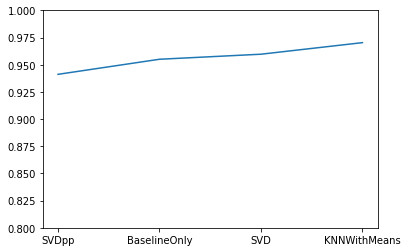

In [51]:
import matplotlib.pyplot as plt

index = np.argsort(results)
plt.ylim(0.8, 1)
plt.plot(names[index], results[index])
results[index]

## 5.3 알고리즘 옵션 지정

In [52]:
# 알고리즘 옵션 변경, 정확도 계산
sim_options = {'name': 'pearson_baseline', 'user_based': True}

algo = KNNWithMeans(k=30, sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9704


0.9703841087419602

## 5.4 다양한 조건의 비교

In [53]:
# 다양한 neighbor size 비교
result = []
for neighbor_size in (10, 20, 30, 40, 50, 60):
    algo = KNNWithMeans(k=neighbor_size, sim_options={'name': 'pearson_baseline', 'user_based': True})
    algo.fit(trainset)
    predictions = algo.test(testset)
    result.append([neighbor_size, accuracy.rmse(predictions)])

result

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9819
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9717
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9704
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9701
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9701
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9701


[[10, 0.9818706950416946],
 [20, 0.9716698867134536],
 [30, 0.9703841087419602],
 [40, 0.9701247487287492],
 [50, 0.9700565896462067],
 [60, 0.9700885841390458]]

In [54]:
from surprise.model_selection import GridSearchCV

# KNN 다양한 파라미터 비교
param_grid = {'k': [5, 10, 15, 25],
              'sim_options': {'name': ['pearson_baseline', 'cosine'],
                              'user_based': [True, False]}
              }
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=4)
gs.fit(data)

# 최적 RMSE 출력
print(gs.best_score['rmse'])

# 최적 RMSE의 parameter
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similar

In [55]:
# SVD 다양한 파라메터 비교
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [70, 80, 90],
              'lr_all': [0.005, 0.006, 0.007],
              'reg_all': [0.05, 0.07, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=4)
gs.fit(data)

# 최적 RMSE 출력
print(gs.best_score['rmse'])

# 최적 RMSE의 parameter
print(gs.best_params['rmse'])

0.9133225078810472
{'n_epochs': 80, 'lr_all': 0.005, 'reg_all': 0.1}


## 5.5 외부데이터 사용

In [56]:
# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./dataset/u.data', names=r_cols, sep='\t', encoding='latin-1')
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

# Train/Test 분리 
trainset, testset = train_test_split(data, test_size=0.25)

# 정확도 계산 
algo = KNNWithMeans()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9469


0.9469055309457518

# 6. 딥러닝을 사용한 추천 시스템

## 6.1 Keras로 MF 구현하기

In [1]:
import pandas as pd
import numpy as np

# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./dataset/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

In [2]:
# train test 분리
from sklearn.utils import shuffle

TRAIN_SIZE = 0.75
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [4]:
# Variable 초기화 
K = 200                             # Latent factor 수 
mu = ratings_train.rating.mean()    # 전체 평균 
M = ratings.user_id.max() + 1       # Number of users
N = ratings.movie_id.max() + 1      # Number of movies

In [5]:
# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [9]:
# Keras model
user = Input(shape=(1, ))
item = Input(shape=(1, ))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [10]:
# R = Dot(axes=2) ([P_embedding, Q_embedding)
R = layers.dot([P_embedding, Q_embedding], axes=2)
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)

# model setting
model = Model(inputs=[user, item], outputs=R)
model.compile(loss=RMSE, optimizer=SGD(), metrics=[RMSE])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 200)       188800      ['input_5[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 200)       336600      ['input_6[0][0]']                
                                                                                            

In [11]:
# model fitting
result = model.fit(
    x=[ratings_train.user_id.values, ratings_train.movie_id.values],
    y=ratings_train.rating.values - mu,
    epochs=60,
    batch_size=256,
    validation_data=(
        [ratings_test.user_id.values, ratings_test.movie_id.values],
        ratings_test.rating.values - mu
    )
)

Epoch 1/60
293/293 [==============================] - 2s 6ms/step - loss: 5.2823 - RMSE: 1.1236 - val_loss: 5.0473 - val_RMSE: 1.1281
Epoch 2/60
293/293 [==============================] - 1s 5ms/step - loss: 4.8204 - RMSE: 1.1217 - val_loss: 4.6120 - val_RMSE: 1.1262
Epoch 3/60
293/293 [==============================] - 1s 5ms/step - loss: 4.4094 - RMSE: 1.1197 - val_loss: 4.2249 - val_RMSE: 1.1244
Epoch 4/60
293/293 [==============================] - 2s 5ms/step - loss: 4.0440 - RMSE: 1.1179 - val_loss: 3.8806 - val_RMSE: 1.1228
Epoch 5/60
293/293 [==============================] - 2s 5ms/step - loss: 3.7191 - RMSE: 1.1164 - val_loss: 3.5745 - val_RMSE: 1.1213
Epoch 6/60
293/293 [==============================] - 2s 6ms/step - loss: 3.4302 - RMSE: 1.1149 - val_loss: 3.3022 - val_RMSE: 1.1198
Epoch 7/60
293/293 [==============================] - 1s 5ms/step - loss: 3.1732 - RMSE: 1.1135 - val_loss: 3.0601 - val_RMSE: 1.1185
Epoch 8/60
293/293 [==============================] - 1s 5ms/s

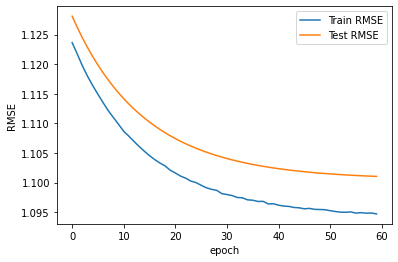

In [12]:
# Plot RMSE
import matplotlib.pyplot as plt

plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")

plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()

plt.show()

In [18]:
# prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]

predictions = model.predict([user_ids, movie_ids]) + mu

print(f'Actuals: \n{ratings_test[0:6]}')
print()
print(f'Predictions: \n{predictions}')

Actuals: 
       user_id  movie_id  rating
62989      764        28       4
5925        86       286       3
59050      437       450       3
77059      643       685       3
81909      654       588       4
12645      244       135       4

Predictions: 
[[3.5830245]
 [3.5631194]
 [3.5060272]
 [3.5351927]
 [3.5561297]
 [3.5839052]]


In [19]:
# RMSE check
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

1.1023434902821574

## 6.2 딥러닝을 적용한 추천 시스템

In [20]:
# keras model
user = Input(shape=(1, ))
item = Input(shape=(1, ))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation

P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])

In [21]:
# Neural network
R = Dense(2048)(R)
R = Activation('linear')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

model = Model(inputs=[user, item], outputs=R)
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RMSE]
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 200)       188800      ['input_7[0][0]']                
                                                                                                  
 embedding_9 (Embedding)        (None, 1, 200)       336600      ['input_8[0][0]']                
                                                                                            

In [22]:
# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values],
  y=ratings_train.rating.values - mu,
  epochs=65,
  batch_size=512,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values],
    ratings_test.rating.values - mu
  )
)

Epoch 1/65
147/147 [==============================] - 6s 40ms/step - loss: 5.3914 - RMSE: 1.1227 - val_loss: 5.2710 - val_RMSE: 1.1279
Epoch 2/65
147/147 [==============================] - 6s 42ms/step - loss: 5.1459 - RMSE: 1.1217 - val_loss: 5.0330 - val_RMSE: 1.1264
Epoch 3/65
147/147 [==============================] - 6s 40ms/step - loss: 4.9147 - RMSE: 1.1195 - val_loss: 4.8084 - val_RMSE: 1.1248
Epoch 4/65
147/147 [==============================] - 5s 35ms/step - loss: 4.6966 - RMSE: 1.1185 - val_loss: 4.5967 - val_RMSE: 1.1234
Epoch 5/65
147/147 [==============================] - 6s 38ms/step - loss: 4.4907 - RMSE: 1.1167 - val_loss: 4.3971 - val_RMSE: 1.1219
Epoch 6/65
147/147 [==============================] - 5s 36ms/step - loss: 4.2966 - RMSE: 1.1149 - val_loss: 4.2086 - val_RMSE: 1.1202
Epoch 7/65
147/147 [==============================] - 5s 34ms/step - loss: 4.1136 - RMSE: 1.1136 - val_loss: 4.0308 - val_RMSE: 1.1185
Epoch 8/65
147/147 [==============================] - 5

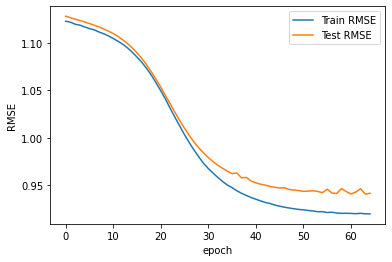

In [23]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [24]:
# Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)

# 정확도(RMSE)를 계산하는 함수 
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

Actuals: 
        user_id  movie_id  rating
62989      764        28       4
5925        86       286       3
59050      437       450       3
77059      643       685       3
81909      654       588       4
12645      244       135       4

Predictions: 
 [[4.17346  ]
 [3.837898 ]
 [2.497438 ]
 [3.382253 ]
 [3.831256 ]
 [4.1608863]]


0.9419615297531404

## 6.3 딥러닝 모델에 변수 추가하기

In [25]:
# 수정된 부분 1 >>>>>>>>>>
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./dataset/u.user', sep='|', names=u_cols, encoding='latin-1')
users = users[['user_id', 'occupation']]

In [26]:
# Convert occupation(string to integer)
occupation = {}
def convert_occ(x):
    if x in occupation:
        return occupation[x]
    else:
        occupation[x] = len(occupation)
        return occupation[x]

users['occupation'] = users['occupation'].apply(convert_occ)

L = len(occupation)
train_occ = pd.merge(ratings_train, users, on='user_id')['occupation']
test_occ = pd.merge(ratings_test, users, on='user_id')['occupation']

In [27]:
# Keras model
user = Input(shape=(1, ))
item = Input(shape=(1, ))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

# 수정된 부분 2 >>>>>>>>>>
occ = Input(shape=(1, ))
occ_embedding = Embedding(L, 3, embeddings_regularizer=l2())(occ)
occ_layer = Flatten()(occ_embedding)
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, occ_layer])
#<<<<<<<<< 수정된 부분 2

# Neural network
R = Dense(2048)(R)
R = Activation('linear')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

# 수정된 부분 3 >>>>>>>>>>
model = Model(inputs=[user, item, occ], outputs=R)

In [28]:
#<<<<<<<<< 수정된 부분 3
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RMSE]
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 1, 200)       188800      ['input_9[0][0]']                
                                                                                            

In [29]:
# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values, train_occ.values],
  y=ratings_train.rating.values - mu,
  epochs=65,
  batch_size=512,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values, test_occ.values],
    ratings_test.rating.values - mu
  )
)

Epoch 1/65
147/147 [==============================] - 6s 38ms/step - loss: 5.4139 - RMSE: 1.1234 - val_loss: 5.2929 - val_RMSE: 1.1282
Epoch 2/65
147/147 [==============================] - 5s 37ms/step - loss: 5.1671 - RMSE: 1.1217 - val_loss: 5.0535 - val_RMSE: 1.1265
Epoch 3/65
147/147 [==============================] - 6s 38ms/step - loss: 4.9346 - RMSE: 1.1197 - val_loss: 4.8278 - val_RMSE: 1.1251
Epoch 4/65
147/147 [==============================] - 6s 39ms/step - loss: 4.7154 - RMSE: 1.1186 - val_loss: 4.6151 - val_RMSE: 1.1237
Epoch 5/65
147/147 [==============================] - 6s 39ms/step - loss: 4.5086 - RMSE: 1.1173 - val_loss: 4.4142 - val_RMSE: 1.1220
Epoch 6/65
147/147 [==============================] - 6s 38ms/step - loss: 4.3136 - RMSE: 1.1152 - val_loss: 4.2249 - val_RMSE: 1.1204
Epoch 7/65
147/147 [==============================] - 5s 36ms/step - loss: 4.1295 - RMSE: 1.1138 - val_loss: 4.0461 - val_RMSE: 1.1187
Epoch 8/65
147/147 [==============================] - 6

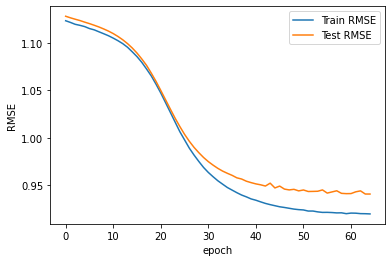

In [30]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [31]:
# Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
user_occ = test_occ[0:6]
predictions = model.predict([user_ids, movie_ids, user_occ]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)

Actuals: 
        user_id  movie_id  rating
62989      764        28       4
5925        86       286       3
59050      437       450       3
77059      643       685       3
81909      654       588       4
12645      244       135       4

Predictions: 
 [[4.1636386]
 [3.9213605]
 [2.4834595]
 [3.3446496]
 [3.794316 ]
 [4.203824 ]]


In [32]:
# 정확도(RMSE)를 계산하는 함수 
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids, test_occ]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

0.9409656895443061

# 7. 하이브리드 추천 시스템

## 7.1 하이브리드 추천 시스템의 원리

In [38]:
# dummy recommender 0
import random

def recommender0(recomm_list):
    recommendations = []
    for _ in recomm_list:
        recommendations.append(random.random() * 4 + 1)
    
    return np.array(recommendations)

# dummy recommender 1
def recommender1(recomm_list):
    recommendations = []
    for _ in recomm_list:
        recommendations.append(random.random() * 4 + 1)
    
    return np.array(recommendations)

In [39]:
# get hybrid result
weight = [0.8, 0.2]
recomm_list = np.array(ratings_test)

predictions0 = recommender0(recomm_list)
predictions1 = recommender1(recomm_list)

predictions = predictions0 * weight[0] + predictions1 * weight[1]
RMSE2(recomm_list[:, 2], predictions)

1.570196772569366

## 7.2 하이브리드 추천 시스템(CF와 MF의 결합)

In [40]:
##### CF 추천 알고리즘 >>>>>>>>>>>>>>>

rating_matrix = ratings_train.pivot(index='user_id', columns='movie_id', values='rating')

In [42]:
# train set 사용자들의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

In [43]:
# train 데이터의 user의 rating 평균과 영화의 평점편차 계산 
rating_mean = rating_matrix.mean(axis=1)
rating_bias = (rating_matrix.T - rating_mean).T

def CF_knn_bias(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_bias:
        sim_scores = user_similarity[user_id]
        movie_ratings = rating_bias[movie_id]
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)
        if neighbor_size == 0:
            prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            prediction = prediction + rating_mean[user_id]
        else:
            if len(sim_scores) > 1:
                neighbor_size = min(neighbor_size, len(sim_scores))
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                user_idx = np.argsort(sim_scores)
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
                prediction = prediction + rating_mean[user_id]
            else:
                prediction = rating_mean[user_id]
    else:
        prediction = rating_mean[user_id]
    return prediction

In [44]:
##### MF 추천 알고리즘 >>>>>>>>>>>>>>>

class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)        
        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # train set의 RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    # Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Test set을 선정
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            z = ratings_test.iloc[i, 2]
            test_set.append([x, y, z])
            self.R[x, y] = 0                    # Setting test set ratings to 0
        self.test_set = test_set
        return test_set                         # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))

    # Training 하면서 test set의 정확도를 계산
    def test(self):
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        prediction = self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])
        return prediction

    # Full user-movie rating matrix
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)

In [45]:
# MF클래스 생성 및 학습
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=200, alpha=0.001, beta=0.02, iterations=250, verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()

Iteration: 10 ; Train RMSE = 0.9675 ; Test RMSE = 0.9821
Iteration: 20 ; Train RMSE = 0.9432 ; Test RMSE = 0.9619
Iteration: 30 ; Train RMSE = 0.9326 ; Test RMSE = 0.9536
Iteration: 40 ; Train RMSE = 0.9265 ; Test RMSE = 0.9491
Iteration: 50 ; Train RMSE = 0.9226 ; Test RMSE = 0.9464
Iteration: 60 ; Train RMSE = 0.9199 ; Test RMSE = 0.9446
Iteration: 70 ; Train RMSE = 0.9177 ; Test RMSE = 0.9434
Iteration: 80 ; Train RMSE = 0.9159 ; Test RMSE = 0.9424
Iteration: 90 ; Train RMSE = 0.9142 ; Test RMSE = 0.9417
Iteration: 100 ; Train RMSE = 0.9123 ; Test RMSE = 0.9409
Iteration: 110 ; Train RMSE = 0.9100 ; Test RMSE = 0.9401
Iteration: 120 ; Train RMSE = 0.9070 ; Test RMSE = 0.9390
Iteration: 130 ; Train RMSE = 0.9026 ; Test RMSE = 0.9375
Iteration: 140 ; Train RMSE = 0.8964 ; Test RMSE = 0.9351
Iteration: 150 ; Train RMSE = 0.8880 ; Test RMSE = 0.9320
Iteration: 160 ; Train RMSE = 0.8773 ; Test RMSE = 0.9283
Iteration: 170 ; Train RMSE = 0.8647 ; Test RMSE = 0.9245
Iteration: 180 ; Train 

In [46]:
##### Hybrid 추천 알고리즘

def recommender0(recomm_list, mf):
    recommendations = np.array([mf.get_one_prediction(user, movie) for (user, movie) in recomm_list])
    return recommendations

def recommender1(recomm_list, neighbor_size=0):
    recommendations = np.array([CF_knn_bias(user, movie, neighbor_size) for (user, movie) in recomm_list])
    return recommendations

In [47]:
recomm_list = np.array(ratings_test.iloc[:, [0, 1]])

predictions0 = recommender0(recomm_list, mf)
RMSE2(ratings_test.iloc[:, 2], predictions0)

predictions1 = recommender1(recomm_list, 37)
RMSE2(ratings_test.iloc[:, 2], predictions1)

weight = [0.8, 0.2]
predictions = predictions0 * weight[0] + predictions1 * weight[1]
RMSE2(ratings_test.iloc[:, 2], predictions)

for i in np.arange(0, 1, 0.01):
    weight = [i, 1.0 - i]
    predictions = predictions0 * weight[0] + predictions1 * weight[1]
    print("Weights - %.2f : %.2f ; RMSE = %.7f" % (weight[0], 
           weight[1], RMSE2(ratings_test.iloc[:, 2], predictions)))

Weights - 0.00 : 1.00 ; RMSE = 0.9449573
Weights - 0.01 : 0.99 ; RMSE = 0.9441236
Weights - 0.02 : 0.98 ; RMSE = 0.9432985
Weights - 0.03 : 0.97 ; RMSE = 0.9424821
Weights - 0.04 : 0.96 ; RMSE = 0.9416744
Weights - 0.05 : 0.95 ; RMSE = 0.9408755
Weights - 0.06 : 0.94 ; RMSE = 0.9400853
Weights - 0.07 : 0.93 ; RMSE = 0.9393039
Weights - 0.08 : 0.92 ; RMSE = 0.9385312
Weights - 0.09 : 0.91 ; RMSE = 0.9377674
Weights - 0.10 : 0.90 ; RMSE = 0.9370124
Weights - 0.11 : 0.89 ; RMSE = 0.9362662
Weights - 0.12 : 0.88 ; RMSE = 0.9355290
Weights - 0.13 : 0.87 ; RMSE = 0.9348006
Weights - 0.14 : 0.86 ; RMSE = 0.9340812
Weights - 0.15 : 0.85 ; RMSE = 0.9333707
Weights - 0.16 : 0.84 ; RMSE = 0.9326691
Weights - 0.17 : 0.83 ; RMSE = 0.9319766
Weights - 0.18 : 0.82 ; RMSE = 0.9312930
Weights - 0.19 : 0.81 ; RMSE = 0.9306185
Weights - 0.20 : 0.80 ; RMSE = 0.9299530
Weights - 0.21 : 0.79 ; RMSE = 0.9292966
Weights - 0.22 : 0.78 ; RMSE = 0.9286492
Weights - 0.23 : 0.77 ; RMSE = 0.9280110
Weights - 0.24 :

# 8. 대규모 데이터의 처리를 위한 희소 행렬 사용

## 8.1 Sparse matrix의 개념과 Python에서의 사용

## 8.2 Sparse matrix를 추천 알고리즘에 적용하기